# FRE6091_HW4_Albert_Lee

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
img = mpimg.imread("hw3_instructions.png")

In [3]:
#fig = plt.figure(figsize=(400, 100))
#imgplot = plt.imshow(img)

a. **Answer:** The stable model satisfies wide-sense stationarity for time seiries data
  
$(1)~E[Y_{t_{i}}] = E[Y_{t_{j}}] = \mu < \infty,~for~all~t_{i} \neq t_{j}$  
  Random variables at different times have the same finite means  
  
$(2)~R_{Y}(t_{i},t_{j})=R_{Y}(t_{i}-t_{j})$  
  Auto-correlation function of different times is as same as the that of the function of the difference and  
  therefore, does not depends on the individual values of time variables.

b. **Answer:**  
We need to look at Autocorration Function and Partial Autocorrlation Function to determine the influence of how many previous lags need to be included in the model. 


### Problem 1

In [4]:
data = pd.read_excel("cpi.xlsx")
data.sort_values(by=['Year'], ascending=True, inplace=True)
#data['log Ave.'] = np.log(data['Ave.'])
data.index = range(len(data['Year']))
data = data.dropna()
print(data.shape)
data.head() 

(107, 14)


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave.
0,1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,9.9
1,1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,10.0
2,1915,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,10.1
3,1916,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,10.9
4,1917,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,12.8


In [5]:
dfcopy = data.copy()

Text(0.5, 1.0, 'Annual Average CPI')

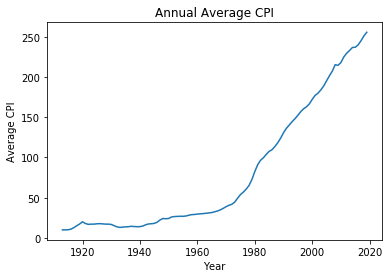

In [6]:
plt.plot(data['Year'], data['Ave.'])
plt.ylabel('Average CPI')
plt.xlabel('Year')
plt.title('Annual Average CPI')

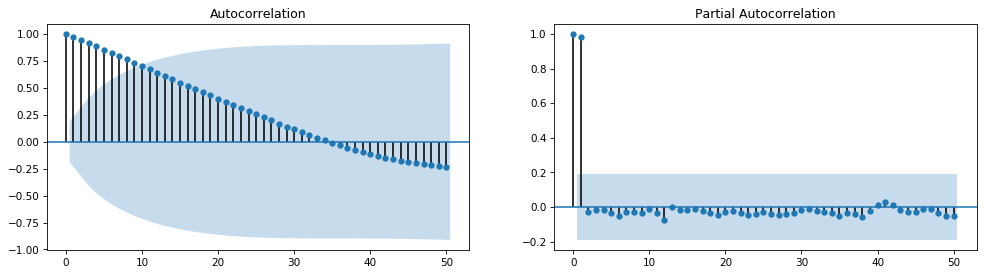

In [7]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
plot_acf(data['Ave.'].tolist(), lags=50, ax=axes[0]);
plot_pacf(data['Ave.'].tolist(), lags=50, ax=axes[1]);

ADF statistic suggests that the data is not stationary. In addition, as we can see from the table and the graph of the raw data, CPI is a cumulative measure of the average spending of households for essential goods. We can assume that the data has with high probability a markov property in which Y(t-1) contains all previous information and so the value of Y(t) will highly depend on Y(t-1) given all previous information. Therefore, at this point, I belive that the AR model is appropriate to detrend the data. I will also check if I need MA terms after further analysis.

**(1) First, transform the data by AR(1) to check if the transformed data is stationary**

**Caculate autocorrelation (lag=1) to determine the coefficient of AR(1)**

In [8]:
a = len(dfcopy['Ave.'])
yt = np.array(dfcopy['Ave.'][1:a])
yt1 = np.array(dfcopy['Ave.'][0:a-1])
cov1 = np.cov(yt, yt1)
print('Autocovariance [y(t), y(t-1)] =', cov1[0, 1])
cor1 = cov1[0, 1] / (np.sqrt(cov1[0, 0]) * np.sqrt(cov1[1, 1]))
b0 = np.mean(yt) - cor1 * np.mean(yt1) 
print('Autocorrelation [y(t), y(t-1)] =', cor1)
yhat = cor1 * yt1 + b0

Autocovariance [y(t), y(t-1)] = 6006.467825603593
Autocorrelation [y(t), y(t-1)] = 0.9997045022550993


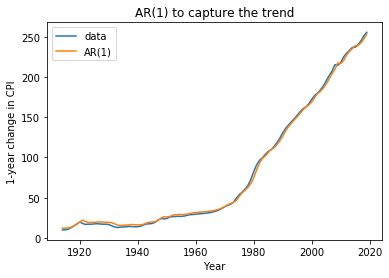

In [9]:
plt.plot(dfcopy['Year'][1:a], yt)
plt.plot(data['Year'][1:a], yhat)
plt.ylabel('1-year change in CPI')
plt.xlabel('Year')
plt.title('AR(1) to capture the trend')
plt.legend(['data', 'AR(1)'])

**Detrend the time series with AR(1) and check for stationarity**

In [10]:
res = yt - yhat
print('Mean of residuals:', np.mean(res))
print('Variance of residuals:', np.var(res))

Mean of residuals: 9.21694586481262e-16
Variance of residuals: 6.153500044296963


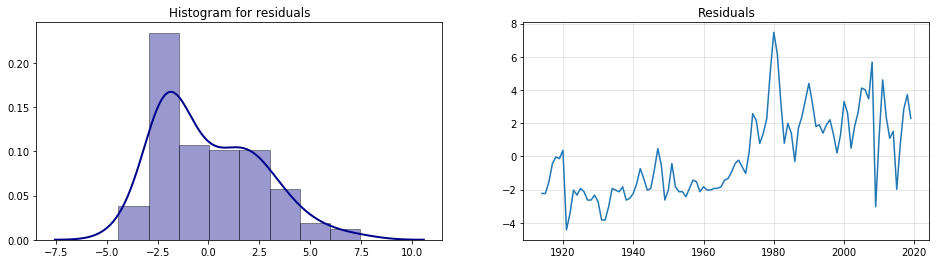

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(res, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0])
ax[0].set_title('Histogram for residuals')
ax[1].plot(dfcopy['Year'][1:a], res)
ax[1].set_title('Residuals')
ax[1].grid(True, alpha=0.4)

Checking the mean of residuals and looking at the graph, the residuals are roughly centered around zero and look a lot similiar to the normal than before.  
To make it better, I will try to add Simple MA model.

**Check if adding Simple MA model to AR(1) can make it better**

In [12]:
ym1 = np.zeros(len(res) - 1)
for i in range(0, len(res)-1):
    ym1[i] = res[i]
res1 = res[1:] - ym1

ym2 = np.zeros(len(res) - 2)
for i in range(1, len(res)-1):
    ym2[i - 1] = (res[i - 1] + res[i]) / 2
res2 = res[2:] - ym2

ym3 = np.zeros(len(res) - 3)
for i in range(2, len(res)-1):
    ym3[i - 2] = (res[i - 2] + res[i - 1] + res[i]) / 3
res3 = res[3:] - ym3

AR(1)+MA(1) residuals mean: 0.04305977261480253
AR(1)+MA(1) residuals variance: 2.566225077455585

AR(1)+MA(2) residuals mean: 0.07211057754382252
AR(1)+MA(2) residuals variance: 2.8509889914505195

AR(1)+MA(3) residuals mean: 0.09209256417366196
AR(1)+MA(3) residuals variance: 2.868213473584188


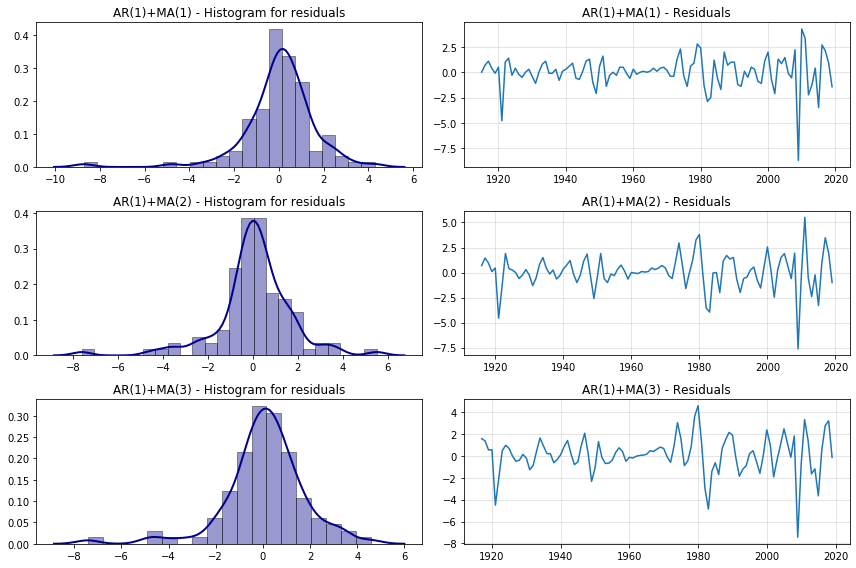

In [13]:
print('AR(1)+MA(1) residuals mean:', np.mean(res1))
print('AR(1)+MA(1) residuals variance:', np.var(res1, ddof=1))
print("")
print('AR(1)+MA(2) residuals mean:', np.mean(res2))
print('AR(1)+MA(2) residuals variance:', np.var(res2, ddof=1))
print("")
print('AR(1)+MA(3) residuals mean:', np.mean(res3))
print('AR(1)+MA(3) residuals variance:', np.var(res3, ddof=1))

fig, ax = plt.subplots(3, 2, figsize=(12, 8))
sns.distplot(res1, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0, 0])
ax[0, 0].set_title('AR(1)+MA(1) - Histogram for residuals')
ax[0, 1].plot(dfcopy['Year'][2:a], res1)
ax[0, 1].set_title('AR(1)+MA(1) - Residuals')
ax[0, 1].grid(True, alpha=0.4)

sns.distplot(res2, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[1, 0])
ax[1, 0].set_title('AR(1)+MA(2) - Histogram for residuals')
ax[1, 1].plot(dfcopy['Year'][3:a], res2)
ax[1, 1].set_title('AR(1)+MA(2) - Residuals')
ax[1, 1].grid(True, alpha=0.4)
plt.tight_layout()

sns.distplot(res3, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[2, 0])
ax[2, 0].set_title('AR(1)+MA(3) - Histogram for residuals')
ax[2, 1].plot(dfcopy['Year'][4:a], res3)
ax[2, 1].set_title('AR(1)+MA(3) - Residuals')
ax[2, 1].grid(True, alpha=0.4)
plt.tight_layout()

Based on the statistic, histograms and the plots, AR(1)+MA(1) model can be chosen.

**(2) Using Python package, apply ARIMA**

Fit ARIMA model

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [15]:
# 1,1,2 ARIMA Model
model = ARIMA(data['Ave.'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Ave.   No. Observations:                  106
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -188.008
Method:                       css-mle   S.D. of innovations              1.416
Date:                Mon, 02 Mar 2020   AIC                            386.017
Time:                        03:56:45   BIC                            399.334
Sample:                             1   HQIC                           391.414
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.3631      1.296      1.824      0.071      -0.177       4.903
ar.L1.D.Ave.     0.9727      0.025     38.878      0.000       0.924       1.022
ma.L1.D.Ave.    -0.2926      0.095     -3.07

The coefficients for AR1, MA1, and MA2 have p-values less than 0.05 and so they are significant.
I will plot the residuals of this model to see if the residuals have a approximately normal distribution.

Check residuals for normality and stationarity

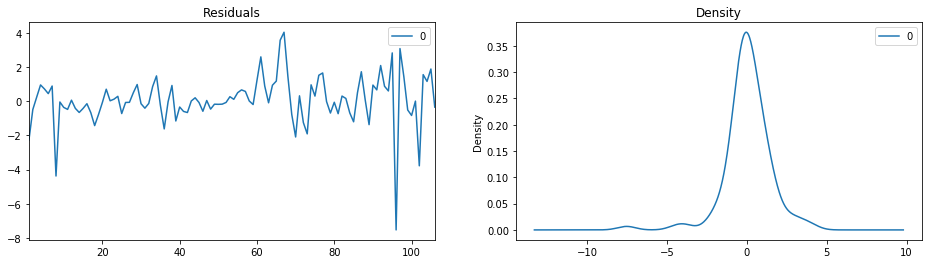

In [16]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(16,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**(3) Conclusion**  
With traditional AR(1) and Simple MA(1), I was able to produce as good a result as the ARIMA model generated by the Python module.  

### Problem 2

**(1) Generate data for the below models and plot the autocorrelation functions.  What do you notice?** 

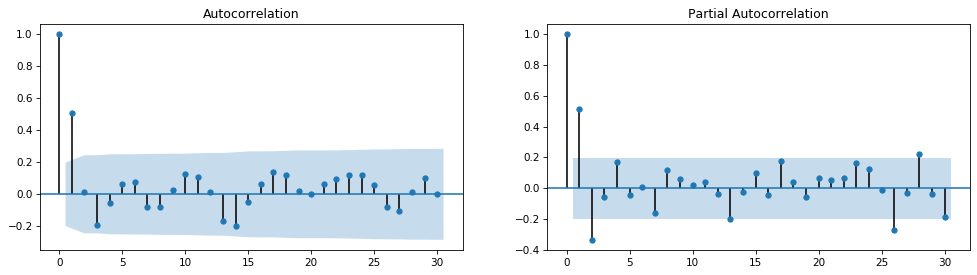

In [17]:
#X(t) = W(t) + 0.7*W(t-1) + 0.2*W(t-2)
np.random.seed(1)
w = np.random.normal(0, 1, size=(100))
#print(w.shape)
x1 = []
for i in range(2, len(w)):
    x1.append(w[i] + 0.7*w[i-1] + 0.2*w[i-2])

fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
plot_acf(x1, lags=30, ax=axes[0]);
plot_pacf(x1, lags=30, ax=axes[1]);

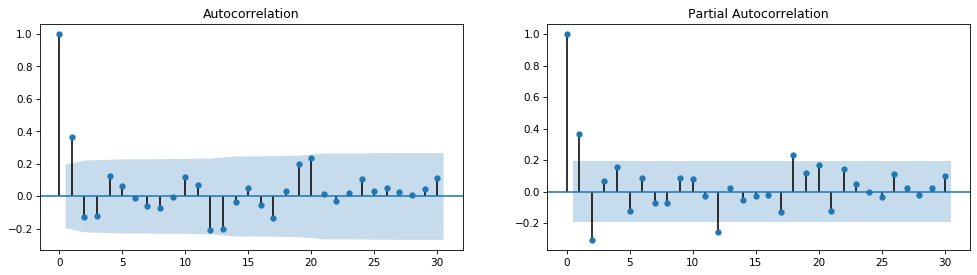

In [18]:
#X(t) - 0.6*X(t-1) + 0.2*X(t-2) = W(t)
w = np.random.normal(0, 1, size=(100))
#print(w.shape)
x2 = list(np.random.randint(0, 1, size=(2)))
for i in range(2, len(w)):
    x2.append(0.6*x2[i-1] - 0.2*x2[i-2] + w[i])

fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
plot_acf(x2, lags=30, ax=axes[0]);
plot_pacf(x2, lags=30, ax=axes[1]);

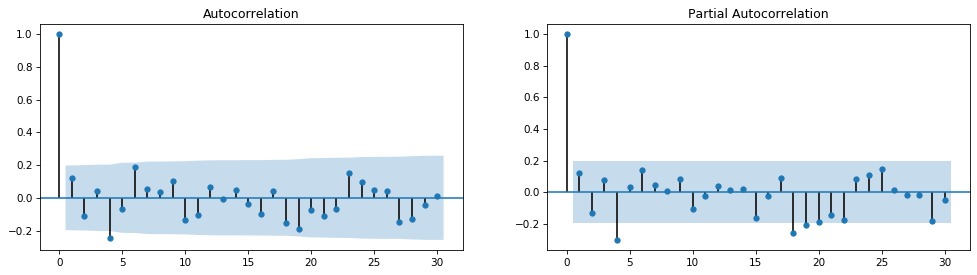

In [19]:
#X(t) - 0.4*X(t-1) = W(t) + 0.2*W(t-1) + 0.3*W(t-2)

w = np.random.normal(0, 1, size=(100))
#print(w.shape)
x3 = list(np.random.normal(0, 1, size=(1)))
for i in range(1, len(w)-1):
    x3.append(0.4*x3[i-1] - w[i+1] + 0.2*w[i] + 0.3*w[i-1])

fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 75)
plot_acf(x3, lags=30, ax=axes[0]);
plot_pacf(x3, lags=30, ax=axes[1]);

**Answer:** I notice that, depending on the maginitude of the coefficients of previous lags, ACF and PACF change. ACF shows significance when there is at least one coefficients with a value greater than 0.5

**(2) Try to find the autocorrelation function of the first model using math.**

In [20]:
df1 = pd.DataFrame(x1, columns=['X(t)'])
xt1 = x1[0:len(x1)-1]
df1.drop(axis=0, index=0, inplace=True)
#df1.head()

In [21]:
df1['X(t-1)'] = xt1
df1['[X(t)-E(X(t))][X(t-1)-E(X(t-1))]'] = (df1['X(t)'] - np.mean(df1['X(t)'])) * (df1['X(t-1)'] - np.mean(df1['X(t-1)'])) 
df1.head()

,X(t),X(t-1),[X(t)-E(X(t))][X(t-1)-E(X(t-1))]
1,-1.565040,-0.631532,1.197306
2,0.008695,-1.565040,0.147369
3,-1.910347,0.008695,0.160254
4,0.306816,-1.910347,-0.417753
5,-0.000146,0.306816,-0.021388


In [22]:
Cov = sum(df1['[X(t)-E(X(t))][X(t-1)-E(X(t-1))]']) / len(df1['X(t-1)'])
Varx = sum((x1 - np.mean(x1) * np.ones_like(x1))**2) / len(x1)

ACF = Cov / Varx

print("ACF using math=", ACF)

ACF using math= 0.5115708159485451
